Курсовой проект представляет из себя Jupiter notebook с обработкой данных и подготовкой модели для участия в соревновании Real Estate Price Prediction на платформе Kaggle.

**Ссылка на соревнование:**

https://www.kaggle.com/c/real-estate-price-prediction-moscow/overview

**Описание соревнования:**

*Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).*

#### Подключение библиотек и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 58 kB/s 


In [3]:
from catboost import CatBoostRegressor

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
matplotlib.rcParams.update({'font.size': 14})

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()   

In [7]:
!mkdir ~/.kaggle
!echo '{"username":"androkotey","key":"95e151f97924bc74f585c8a071d8fa62"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c real-estate-price-prediction-moscow
!unzip real-estate-price-prediction-moscow.zip -d /content/

  0% 0.00/70.0k [00:00<?, ?B/s]
100% 70.0k/70.0k [00:00<00:00, 26.6MB/s]
  0% 0.00/475k [00:00<?, ?B/s]
100% 475k/475k [00:00<00:00, 65.8MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.4MB/s]
Archive:  train.csv.zip
  inflating: /content/train.csv      


In [8]:
TRAIN_DATASET_PATH = '/content/train.csv'
TEST_DATASET_PATH = '/content/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
* **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры (**target**)



In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [10]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [13]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [14]:
np.all(train_df.dtypes.drop('Price') == test_df.dtypes)

True

### EDA

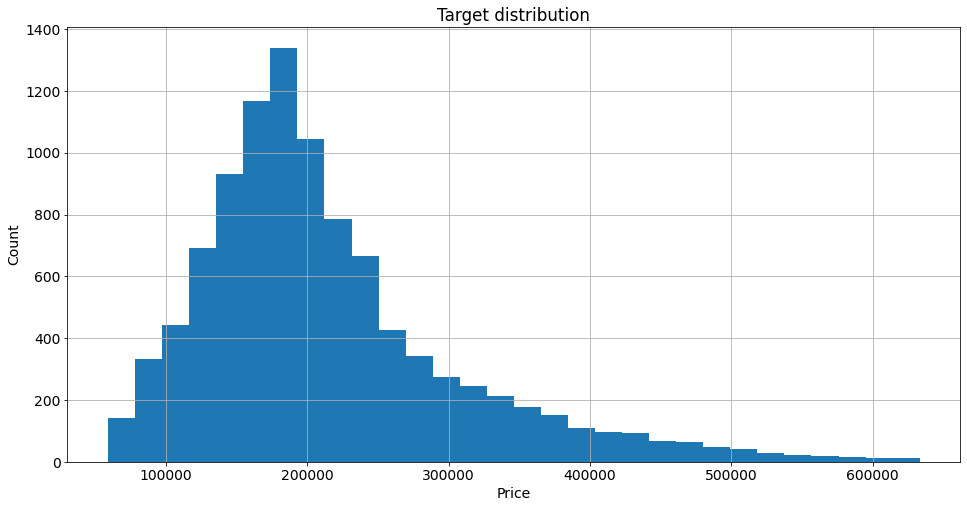

In [15]:
plt.figure(figsize = (16,8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**Посмотрим на числовые признаки**

In [17]:
# в том датасете, что был у преподавателя, эти два столбца имели строковый тип
train_df['Id'] = train_df['Id'].astype('str')
train_df['DistrictId'] = train_df['DistrictId'].astype('str')

In [18]:
data_num_features = train_df.select_dtypes(include=['float64', 'int64'])
data_num_features.drop('Price', axis=1, inplace=True)

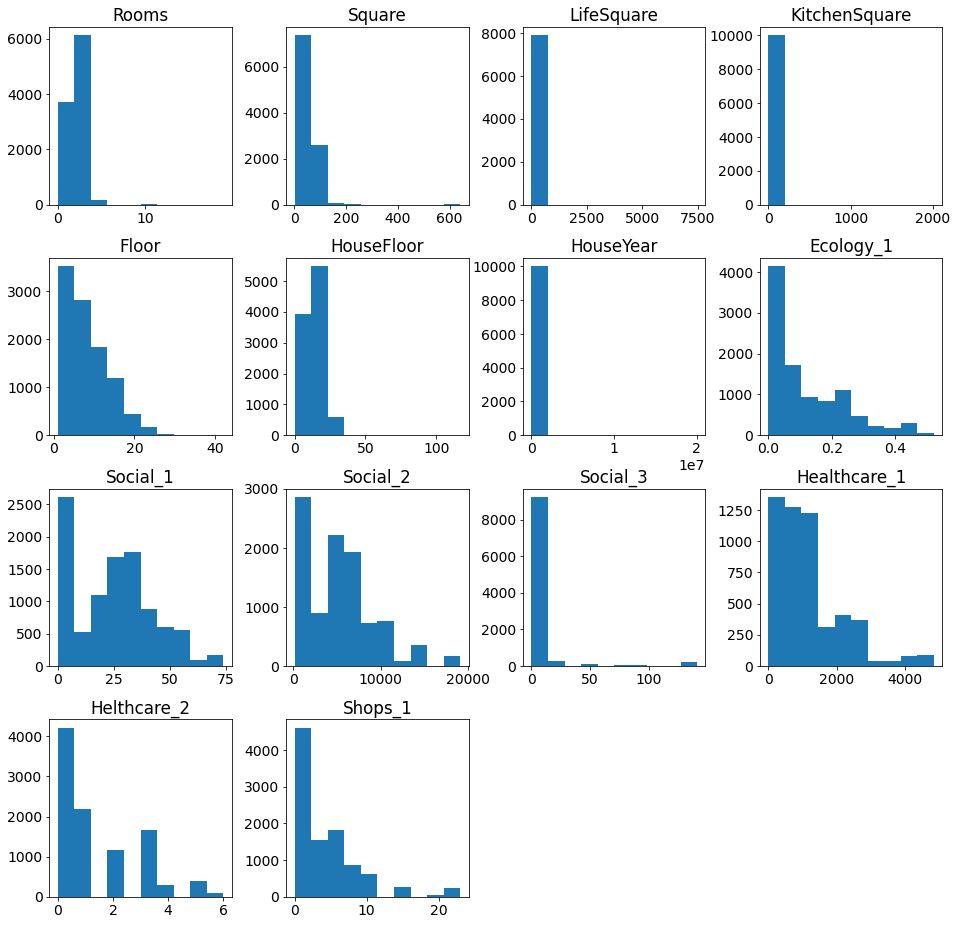

In [19]:
data_num_features.hist(figsize=(16,16), bins=10, grid=False);

Судя по графикам, в некоторых признаках присутствуют выбросы (Rooms, Square, LifeSquare, KitchenSquare, HouseFloor, HouseYear). Некоторые признаки имеют следы замены части значений нулевыми (например, Ecology_1, Social_1).



---

**Social_3 - важный для модели признак и имеет странное распределение**

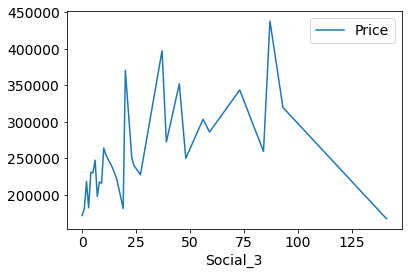

In [20]:
train_df.groupby(['Social_3'], as_index=False).agg({'Price':'median'}).plot(x='Social_3', y='Price')

Посмотрим также на тестовый набор данных

In [21]:
test_df['Social_3'].value_counts().sort_index()

0      1470
1       896
2       323
3       540
4       444
5       201
6       214
7        92
8        77
9       116
10       85
11       96
14       53
16       46
19       12
20        6
23       14
24       20
27       22
37        2
39       17
45        5
48       36
56       19
59       11
73        9
84       32
87       10
93       12
141     120
Name: Social_3, dtype: int64

Значение 141 похоже на заглушку, при чём может означать, например 11 или 14. Но ценовая категория квартир ближе к 0, поэтому можно попробовать заменить нулём, а также добавить соответствующий признак.


---

**Посмотрим на строковые признаки**

In [22]:
data_obj_features = train_df.select_dtypes(include=['object'])

In [23]:
for feature in data_obj_features.columns.tolist():
    print(feature)
    print(train_df[feature].value_counts())
    print('-------------')

Id
11809    1
2906     1
5039     1
6213     1
12319    1
        ..
2351     1
13054    1
1512     1
11813    1
7202     1
Name: Id, Length: 10000, dtype: int64
-------------
DistrictId
27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64
-------------
Ecology_2
B    9903
A      97
Name: Ecology_2, dtype: int64
-------------
Ecology_3
B    9725
A     275
Name: Ecology_3, dtype: int64
-------------
Shops_2
B    9175
A     825
Name: Shops_2, dtype: int64
-------------


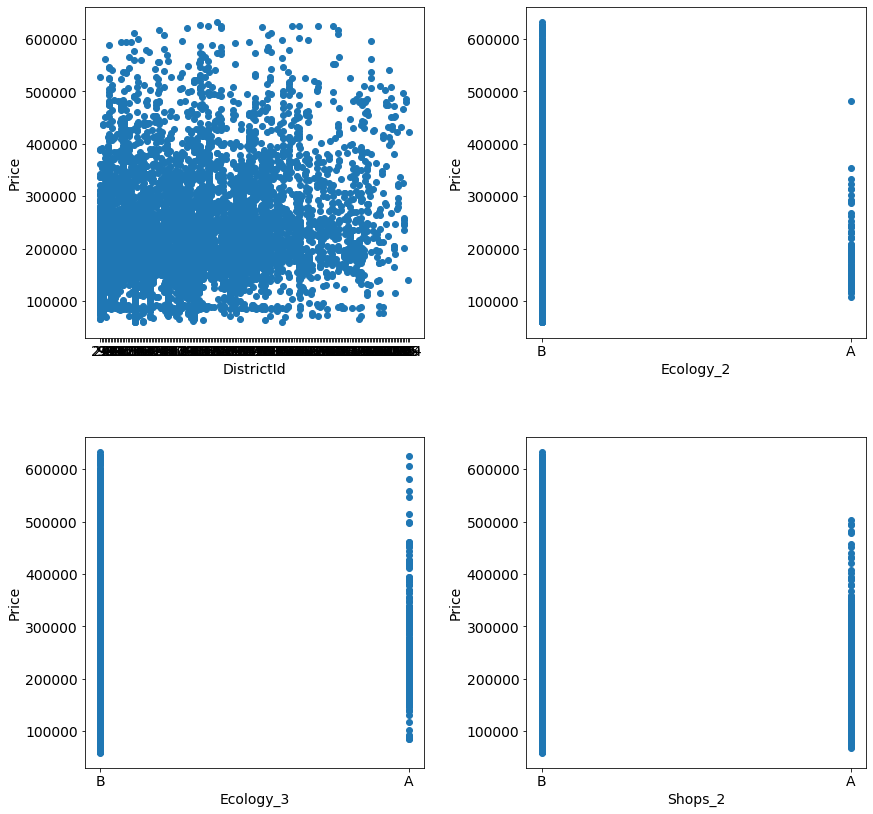

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax = ax.flatten()

for i, col in enumerate(data_obj_features.drop('Id', axis=1).columns):
    ax[i].scatter(data_obj_features[col], train_df['Price'])
    ax[i].set_ylabel('Price')
    ax[i].set_xlabel(col)

fig.subplots_adjust(hspace= 0.3, wspace=0.3)

### Обработка выбросов



*   **Square + создание Square_outlier**



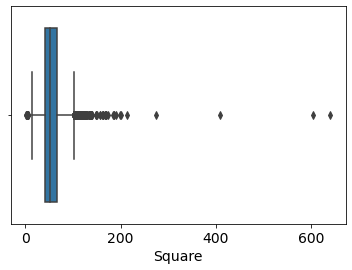

In [25]:
sns.boxplot(train_df['Square'])

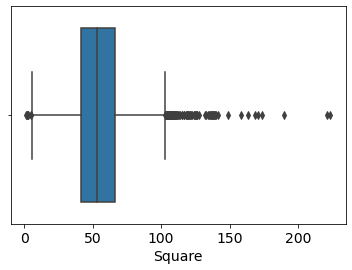

In [26]:
sns.boxplot(test_df['Square'])

In [27]:
train_df['Square_outlier'] = 0

condition = (train_df['Square'] > 300) & (train_df['Rooms'] <= 5)
train_df.loc[condition, 'Square_outlier'] = 1
train_df.loc[condition, 'Square'] = (train_df.loc[condition, 'Square']) / 10

train_df.loc[(train_df['Square'] > 100) | (train_df['Square'] < 10), 'Square_outlier'] = 1
train_df.loc[train_df['Square'] > 100, 'Square'] = 100
train_df.loc[train_df['Square'] < 10, 'Square'] = 10

In [28]:
train_df['Square_outlier'] = 0
train_df.loc[(train_df['Square'] > 100) | (train_df['Square'] < 10), 'Square_outlier'] = 1
train_df.loc[train_df['Square'] > 100, 'Square'] = 100
train_df.loc[train_df['Square'] < 10, 'Square'] = 10

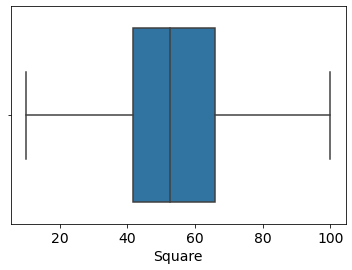

In [29]:
sns.boxplot(train_df['Square'])



*  **Rooms + создание Rooms_outlier**



In [30]:
train_df['Rooms'].value_counts().sort_index()

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Будем считать за выбросы Rooms >= 6

In [31]:
# признак выброса Rooms
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Rooms_outlier
0,11809,27,3.0,100.000000,NaN,10.0,4,10.0,2014,0.075424,...,11,3097,0,NaN,0,0,B,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,264,0,NaN,0,1,B,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,NaN,0,6,B,343995.102962,0,0


In [32]:
# замена нулевых значений и выбросов Rooms
rooms_median = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = rooms_median

In [33]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64



*   **KitchenSquare**



In [34]:
train_df['KitchenSquare'].value_counts().sort_index()

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [35]:
train_df['KitchenSquare'].quantile(.95), train_df['KitchenSquare'].quantile(.025)

(12.0, 0.0)

In [36]:
# замена близких к нулю значений и выбросов KitchenSquare
kitchen_square_median = train_df['KitchenSquare'].median()
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.95))
        
train_df.loc[condition, 'KitchenSquare'] = kitchen_square_median

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [37]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1294
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
4.0       39
Name: KitchenSquare, dtype: int64


*   **HouseFloor + создание HouseFloor_outlier, Floor**


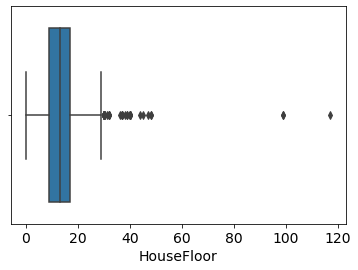

In [38]:
sns.boxplot(train_df['HouseFloor'])

In [39]:
train_df[['HouseFloor', 'Floor']]

,HouseFloor,Floor
0,10.0,4
1,8.0,7
2,17.0,2
3,22.0,10
4,16.0,16
...,...,...
9995,12.0,3
9996,0.0,13
9997,5.0,3
9998,9.0,3


In [40]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [41]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

Этажность дома может быть нулевой, а этаж квартиры - нет. Такого не должно быть, к тому же следует проверить, чтобы этаж квартиры не был больше этажности дома.

In [42]:
# train_df['Floor'] = train_df['Floor'] - 1

In [43]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [44]:
# признак выброса HouseFloor
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [45]:
# замена нулевой этажности дома медианой
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [46]:
# ограничение этажа квартиры этажностью дома
condition = train_df['Floor'] > train_df['HouseFloor']
train_df.loc[condition, 'Floor'] = train_df.loc[condition, 'HouseFloor']

In [47]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0



*   **HouseYear**



In [48]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [49]:
# замена выбросов годом сбора датасета
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Пропущенные значения

In [50]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Square_outlier           0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [51]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,100.000000,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0




*   **LifeSquare + создание LifeSquare_nan**



In [52]:
# новый признак пропуска в LifeSquare
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

In [53]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
condition.sum()

2113

In [54]:
# вычисление пропущенных значений LifeSquare
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [55]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
condition.sum()

0



*   **Healthcare_1**


In [56]:
train_df['Healthcare_1'].value_counts().sort_index()

0.0         1
30.0      348
32.0       12
35.0        2
46.0       49
         ... 
4087.0     45
4129.0     37
4508.0     46
4702.0     27
4849.0     15
Name: Healthcare_1, Length: 79, dtype: int64

In [57]:
# замена пропущенных значений в Healthcare_1
train_df['Healthcare_1'].fillna(0, inplace=True)

In [58]:
train_df['Healthcare_1'].value_counts().sort_index()

0.0       4799
30.0       348
32.0        12
35.0         2
46.0        49
          ... 
4087.0      45
4129.0      37
4508.0      46
4702.0      27
4849.0      15
Name: Healthcare_1, Length: 79, dtype: int64

### Базовый класс для подготовки данных (работа с имеющимися признаками)

In [59]:
class DataPreprocessing:
    """Класс для предобработки тренировочного и тестового набора данных"""

    def __init__(self, kitchen_square_quantile=0.975, kitchen_square_min_threshold=3, balcony_square=3):
        """Параметры для предобработки"""
        self.medians = None
        self.kitchen_square_quantile = kitchen_square_quantile
        self.kitchen_square_min_threshold = kitchen_square_min_threshold
        self.balcony_square = balcony_square
    
    def fit(self, X):
        """Вычисление статистик"""
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(self.kitchen_square_quantile)
    
    def transform(self, X):
        """Предобработка данных"""

        # # Square
        # X['Square_outlier'] = 0
        # X.loc[(X['Square'] > 250) & (X['Rooms'] <= 4), 'Square_outlier'] = 1
        # X.loc[(X['Square'] > 250) & (X['Rooms'] <= 4), 'Square'] = (X.loc[(X['Square'] > 250) & (X['Rooms'] <= 4), 'Square']) / 10

        # X.loc[(X['Square'] > 100) | (X['Square'] < 10), 'Square_outlier'] = 1
        # X.loc[X['Square'] > 100, 'Square'] = 100
        # X.loc[X['Square'] < 10, 'Square'] = 10


        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < self.kitchen_square_min_threshold, 'KitchenSquare'] = self.kitchen_square_min_threshold
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        

        condition = X['Floor'] > X['HouseFloor']
        X.loc[condition, 'HouseFloor'] = X.loc[condition, 'Floor']
        
        # HouseYear
        current_year = 2020
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        X['Healthcare_1'].fillna(0, inplace=True)
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - self.balcony_square      
        
        # новые

        # Social_3
        # X['Social_3_outlier'] = 0
        # X.loc[X['Social_3'] == 141, 'Social_3_outlier'] = 1

        # X.loc[X['Social_3'] == 141, 'Social_3'] = 0


        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков



*   **Перекодирование Ecology_2, Ecology_3 и Shops_2**





In [60]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)


*   **Создание признаков District_Size, IsDistrictLarge**

In [61]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                            .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [62]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Square_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,0.0,0,0,1,305018.871089,0,0,0,1,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1183.0,1,0,1,177734.553407,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,240.0,3,1,1,282078.720850,0,0,0,0,652
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0.0,0,1,1,168106.007630,0,0,0,1,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0.0,0,6,1,343995.102962,0,0,0,0,89


In [63]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [64]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Square_outlier',
       'Rooms_outlier', 'HouseFloor_outlier', 'LifeSquare_nan', 'DistrictSize',
       'IsDistrictLarge'],
      dtype='object')



*   **Создание признака MedPriceByDistrict**



In [65]:
med_price_by_district = train_df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,MedPriceByDistrict
0,0,165963.054142
1,1,183663.443595
2,10,217749.656911
3,100,234032.836228
4,101,184276.502773


In [66]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Square_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,0,1,305018.871089,0,0,0,1,851,1,146171.433190
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,78,0,183678.134031
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,652,1,183663.443595
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,1,1,168106.007630,0,0,0,1,652,1,183663.443595
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,0,89,0,181706.718894




*   **Создание признаков year_cat и floor_cat**



In [67]:
def floor_to_cat(X):
    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat(X):
    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [68]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Square_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,305018.871089,0,0,0,1,851,1,146171.433190,5.0,1.0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,177734.553407,0,0,0,0,78,0,183678.134031,2.0,2.0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,282078.720850,0,0,0,0,652,1,183663.443595,3.0,0.0
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,168106.007630,0,0,0,1,652,1,183663.443595,2.0,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,343995.102962,0,0,0,0,89,0,181706.718894,2.0,4.0




*   **Создание признака MedPriceByFloorYear**



In [69]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.720682
1,0.0,-1.0,263299.720173
2,0.0,0.0,410299.956558
3,0.0,1.0,324303.812481
4,0.0,2.0,423580.477982


In [70]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlier,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,0,0,0,1,851,1,146171.433190,5.0,1.0,161744.506404
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,0,78,0,183678.134031,2.0,2.0,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,0,652,1,183663.443595,3.0,0.0,205210.068542
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,0,0,1,652,1,183663.443595,2.0,3.0,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,0,89,0,181706.718894,2.0,4.0,175503.767602




*   **Создание признака square_to_cat**


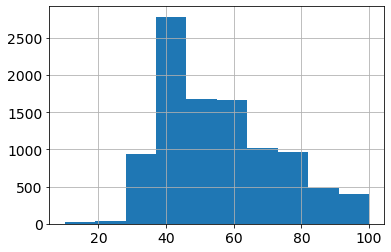

In [71]:
train_df['Square'].hist()

In [72]:
train_df['Square'].value_counts()

100.000000    259
10.000000      12
30.063248       1
76.603972       1
34.544550       1
             ... 
50.933746       1
43.752666       1
65.818506       1
65.688757       1
35.815476       1
Name: Square, Length: 9731, dtype: int64

In [73]:
def square_to_cat(X):
    bins = [X['Square'].min(), 40, 50, 60, 70, 80, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

In [74]:
train_df = square_to_cat(train_df)

In [75]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,square_cat
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,0,0,1,851,1,146171.433190,5.0,1.0,161744.506404,5.0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,0,78,0,183678.134031,2.0,2.0,192213.977261,0.0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,0,652,1,183663.443595,3.0,0.0,205210.068542,4.0
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,0,1,652,1,183663.443595,2.0,3.0,184374.328532,1.0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,0,89,0,181706.718894,2.0,4.0,175503.767602,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981,0.300323,...,0,0,0,118,1,222772.782655,3.0,0.0,205210.068542,1.0
9996,16265,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977,0.072158,...,0,1,0,851,1,146171.433190,2.0,3.0,184374.328532,3.0
9997,2795,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958,0.460556,...,0,0,0,7,0,204858.524238,2.0,0.0,179646.198587,0.0
9998,14561,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969,0.194489,...,0,0,0,165,1,181779.720351,2.0,0.0,179646.198587,0.0




*   **Создание признака MedPriceBySquare**


In [76]:
med_price_by_square = train_df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
med_price_by_square.head()

,square_cat,MedPriceBySquare
0,-1.0,209575.753425
1,0.0,158611.394377
2,1.0,174216.778670
3,2.0,219586.448368
4,3.0,209570.826086


In [77]:
train_df = train_df.merge(med_price_by_square, on=['square_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear,square_cat,MedPriceBySquare
0,11809,27,3.0,100.000000,87.000000,10.0,4.0,10.0,2014,0.075424,...,0,1,851,1,146171.433190,5.0,1.0,161744.506404,5.0,296590.662270
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,0,0,78,0,183678.134031,2.0,2.0,192213.977261,0.0,158611.394377
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,0,0,652,1,183663.443595,3.0,0.0,205210.068542,4.0,299028.138371
3,2352,1,1.0,40.409907,34.409907,3.0,10.0,22.0,1977,0.007122,...,0,1,652,1,183663.443595,2.0,3.0,184374.328532,1.0,174216.778670
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,0,0,89,0,181706.718894,2.0,4.0,175503.767602,3.0,209570.826086


### Класс для добавления новых признаков в набор данных

In [93]:
class FeatureGenetator():
    """Класс для добавления новых признаков в набор данных"""
    
    def __init__(self, large_district_threshold=100):
        """Параметры признаков"""
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_square = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
        self.large_district_threshold = large_district_threshold
        
    def fit(self, X, y=None):
        """Получение статистик"""
        X = X.copy()

        self.binary_to_numbers = {'A': 0, 'B': 1}
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
  
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()

            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)

            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()

            self.med_price_by_square = df.groupby(['square_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
            self.med_price_by_square_median = self.med_price_by_square['MedPriceBySquare'].median()

    def transform(self, X):
        """Трансформация данных"""
        # Кодирование бинарных признаков
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge, new_district
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > self.large_district_threshold).astype(int)
        
        # Добавление категорий floor_to_cat, year_to_cat
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        X = self.square_to_cat(X)
        
        # MedPriceByDistrict, MedPriceByFloorYear
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        # MedPriceBySquare
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['square_cat'], how='left')
            X['MedPriceBySquare'].fillna(self.med_price_by_square_median, inplace=True)

        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
    
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

    def square_to_cat(self, X):
        bins = [X['Square'].min(), 40, 50, 60, 70, 80, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
        X['square_cat'].fillna(-1, inplace=True)
        return X

### Все признаки

In [94]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [95]:
# Без Floor и Healthcare_1
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear', 'year_cat']

target_name = 'Price'

### Подготовка финальных данных

In [106]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [107]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [108]:
train_df = pd.concat([train_df, train_df[train_df['Price'] >= 400000]])

In [109]:
train_df.loc[train_df['KitchenSquare'] == 1970, 'HouseYear'] = 1970
train_df.loc[train_df['KitchenSquare'] == 2014, 'HouseYear'] = 2014
train_df.loc[train_df['KitchenSquare'] == 1970, 'KitchenSquare'] = None
train_df.loc[train_df['KitchenSquare'] == 2014, 'KitchenSquare'] = None

In [110]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
# train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [111]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [112]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [113]:
preprocessor = DataPreprocessing(kitchen_square_quantile=0.95, kitchen_square_min_threshold=3,
                                 balcony_square=5)
                             
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)

X_train.shape, X_valid.shape

((8433, 23), (2109, 23))

In [114]:
features_gen = FeatureGenetator(large_district_threshold=100)
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)

X_train.shape, X_valid.shape

((8433, 32), (2109, 32))

In [115]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]

In [116]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum()

(0, 0)

### Построение, обучение и валидация модели

In [117]:
model = CatBoostRegressor(
    learning_rate=0.03,
    depth=9,
    l2_leaf_reg=2,
    iterations=1000,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True,
)
model.fit(X_train, y_train)

Train R2:	0.951
Test R2:	0.831


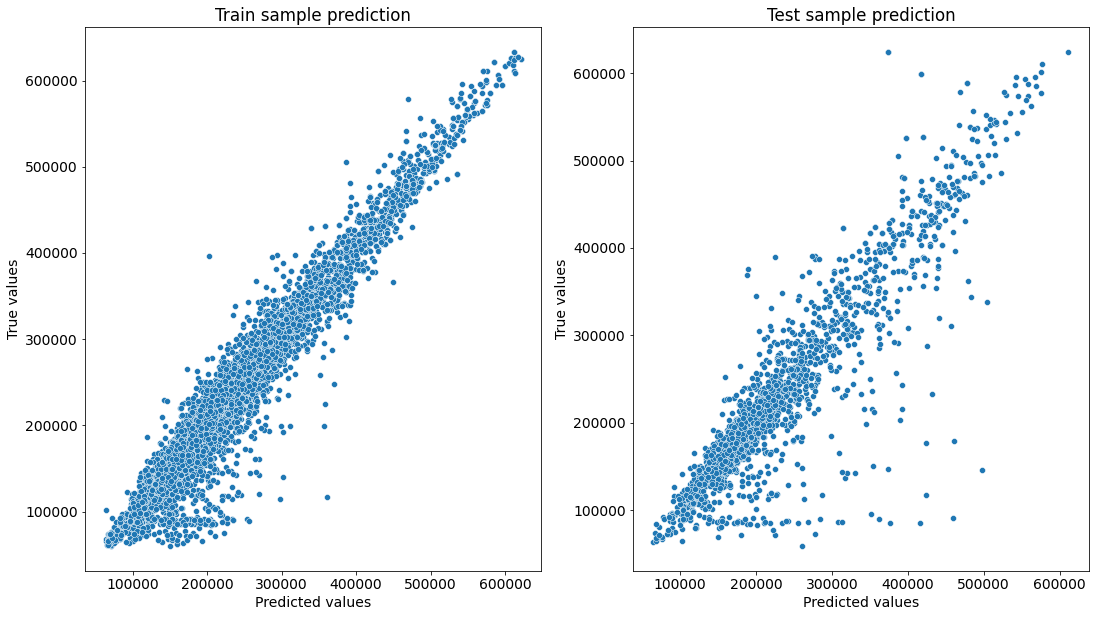

In [118]:
y_train_preds = model.predict(X_train)
y_valid_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [119]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.83399047, 0.82180567, 0.83143288])

In [120]:
cv_score.mean()

0.8290763379819793

In [121]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,26.716709
22,MedPriceByDistrict,18.641072
23,MedPriceByFloorYear,5.607244
11,Social_3,4.995313
3,KitchenSquare,4.903416
19,DistrictSize,4.455070
5,HouseYear,4.453855
2,LifeSquare,4.339919
4,HouseFloor,4.192810
0,Rooms,3.834911


### Изучение ошибок

In [122]:
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9937,6149,53,4.0,109.905861,94.268671,20.0,12,24.0,2018,0.049637,B,B,34,7759,0,229.0,1,3,B,492943.252891
9950,5383,48,3.0,98.994909,NaN,0.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446
9955,16557,65,2.0,57.309254,34.105386,8.0,11,11.0,1957,0.081943,B,B,20,2738,20,NaN,1,4,B,403476.612413
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705


In [123]:
y_valid[(np.abs(y_valid - y_valid_preds) > 100000)]

5405    624008.535763
5652    136963.323425
7529    525449.074107
4957    142601.394005
7371    391390.261824
            ...      
864     146061.730565
1404    589179.481171
9995    119367.455796
7664    129867.099213
5075    331910.236530
Name: Price, Length: 94, dtype: float64

In [124]:
error_log = train_df.iloc[y_valid[(np.abs(y_valid - y_valid_preds) > 110000)].index.values]

In [125]:
error_log[error_log['Price'] < 300000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5652,4802,9,3.0,102.056968,105.272335,10.0,2,17.0,2014,0.161532,B,B,25,5648,1,30.0,2,4,B,136963.323425
4957,7153,8,3.0,78.547592,41.423458,8.0,12,14.0,1995,0.219006,B,B,28,6746,3,NaN,1,4,B,142601.394005
2849,8292,83,3.0,76.415076,48.578347,10.0,18,16.0,1987,0.100456,B,B,43,7227,0,NaN,1,6,A,86975.007476
5127,14825,152,3.0,88.978324,56.939045,12.0,7,7.0,1958,0.042032,B,B,37,6856,84,1940.0,2,5,B,85499.969325
1319,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,1988,0.306977,B,B,27,5148,14,1575.0,5,7,B,59174.778028
6236,10200,157,2.0,43.630022,25.185819,7.0,9,9.0,1970,0.000000,B,B,30,7538,87,4702.0,5,5,B,89882.134908
970,14938,168,1.0,55.545354,22.696217,13.0,14,15.0,2012,0.341072,B,B,27,5664,48,2300.0,3,11,B,128832.535302
416,2026,44,3.0,83.268318,52.024076,10.0,23,23.0,2008,0.232205,B,B,24,4860,1,80.0,0,3,B,117667.742820
4377,8650,19,2.0,63.161892,33.287808,6.0,6,5.0,1961,0.309479,B,B,35,7715,4,990.0,0,6,B,88212.177998
9777,10084,194,2.0,56.622467,31.152720,9.0,2,5.0,1953,0.174739,B,B,17,3379,9,100.0,0,3,B,236662.519826


In [126]:
error_log[error_log['Price'] > 300000]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5405,6323,162,3.0,93.815902,61.816690,9.0,6,6.0,1952,0.174739,B,B,17,3379,9,100.0,0,3,B,624008.535763
7529,11362,107,3.0,76.734669,50.589224,8.0,3,10.0,1958,0.174739,B,B,17,3379,9,100.0,0,3,B,525449.074107
7371,15261,22,3.0,83.162217,1.318250,1.0,8,1.0,2018,0.118537,B,B,30,6207,1,1183.0,1,0,B,391390.261824
2844,14248,105,3.0,71.093710,46.573040,7.0,6,5.0,1931,0.042307,B,B,17,2810,9,4849.0,3,6,B,387442.885760
8373,15710,36,2.0,58.407010,36.067906,9.0,7,14.0,2012,0.087619,B,B,8,1497,5,NaN,1,0,B,376494.333962
1401,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
7430,4338,30,2.0,83.323981,NaN,1.0,8,17.0,2017,0.000078,B,B,22,6398,141,1046.0,3,23,B,389814.111752
4234,10741,155,3.0,78.520750,45.130305,9.0,16,16.0,1989,0.042307,B,B,17,2810,9,4849.0,3,6,B,598541.346385
5282,8657,201,2.0,41.568425,28.916641,5.0,8,9.0,1969,0.081943,B,B,20,2738,20,NaN,1,4,B,349075.091920
1606,3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,NaN,2,6,B,338644.075979


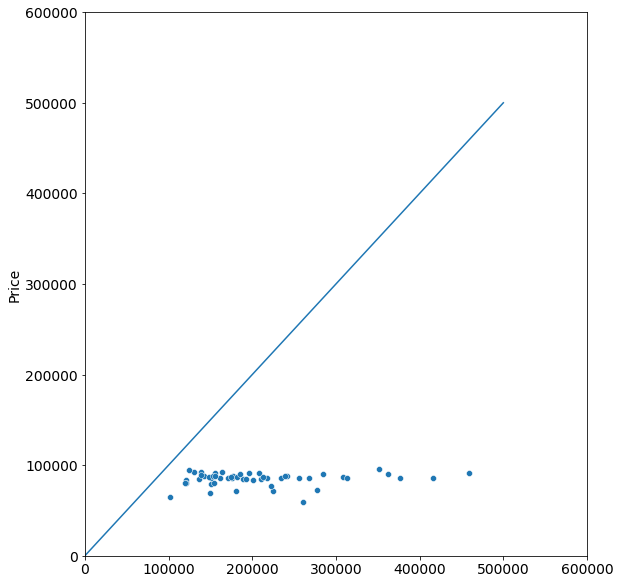

In [130]:
condition = (np.abs(y_valid - y_valid_preds) > 25000) & (y_valid < 100000)

plt.figure(figsize=(9,10))
plt.axis([0, 600000, 0, 600000])
plt.plot([0, 500000], [0, 500000])

sns.scatterplot(x=y_valid_preds[condition], y=y_valid[condition])

Пр

### Обучение на всех данных

In [131]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = pd.concat([train_df, train_df[train_df['Price'] >= 400000]])
test_df = pd.read_csv(TEST_DATASET_PATH)

In [132]:
train_df.shape

(10542, 20)

In [133]:
train_df.loc[train_df['KitchenSquare'] == 1970, 'HouseYear'] = 1970
train_df.loc[train_df['KitchenSquare'] == 2014, 'HouseYear'] = 2014
train_df.loc[train_df['KitchenSquare'] == 1970, 'KitchenSquare'] = None
train_df.loc[train_df['KitchenSquare'] == 2014, 'KitchenSquare'] = None

In [134]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2011
# train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [135]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [136]:
preprocessor = DataPreprocessing(kitchen_square_quantile=0.95, kitchen_square_min_threshold=3,
                                 balcony_square=5)

In [137]:
preprocessor.fit(X)

X = preprocessor.transform(X)
test_df = preprocessor.transform(test_df)

In [139]:
features_gen = FeatureGenetator(large_district_threshold=100)
features_gen.fit(X, y)

X = features_gen.transform(X)
test_df = features_gen.transform(test_df)

In [140]:
X = X[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [141]:
model = CatBoostRegressor(
    learning_rate=0.03,
    depth=9,
    l2_leaf_reg=2,
    iterations=1000,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=21,
    silent=True
)
model.fit(X, y)

### Submit

In [156]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear,year_cat
0,1.0,36.847630,19.094182,5.0,9.0,1970,0.036122,1,1,24,...,0,0,0,0,106.0,0,1,209526.766734,189266.166676,2.0
1,1.0,42.493907,42.568133,10.0,17.0,2017,0.072158,1,1,2,...,0,0,0,0,248.0,0,1,162302.635671,183536.362316,5.0
2,2.0,59.463678,45.463678,9.0,19.0,1977,0.211401,1,1,9,...,0,0,0,1,852.0,0,1,146209.519393,184467.182194,2.0
3,3.0,49.646030,33.893825,6.0,2.0,1965,0.014073,1,1,2,...,0,0,0,0,566.0,0,1,113919.670183,181917.639413,2.0
4,1.0,53.837056,45.837056,3.0,17.0,1977,0.309479,1,1,35,...,0,0,0,1,115.0,0,1,195831.983247,190755.601590,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,6.0,1962,0.069660,1,1,31,...,0,1,0,0,91.0,0,0,179174.432556,190755.601590,2.0
4996,3.0,93.698122,94.521465,10.0,27.0,2018,0.060753,1,1,15,...,0,0,0,0,48.0,0,0,388194.557801,223793.663751,5.0
4997,1.0,33.656723,19.003259,5.0,5.0,1966,0.038693,1,1,28,...,0,0,0,0,98.0,0,0,184510.083016,181917.639413,2.0
4998,1.0,38.635155,20.976257,9.0,14.0,1970,0.089040,1,1,33,...,0,0,0,0,57.0,0,0,218489.404742,190755.601590,2.0


In [157]:
submit = pd.read_csv('/content/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [158]:
predictions = model.predict(test_df)
predictions

array([164620.25037555, 121070.82481018, 149094.27240664, ...,
       148020.77060358, 191082.04277449, 248081.0325044 ])

Лучший результат получен смешиванием результата работы моей модели и лучшей общедоступной.

In [159]:
# # Mix
# gb_submit = pd.read_csv('/content/gb_submit.csv')
# gb_submit.head()

In [160]:
# submit['Price'] = (predictions + gb_submit['Price']) / 2 # score 0.78426
submit['Price'] = predictions # score 0.77915
submit.head()

,Id,Price
0,4567,164620.250376
1,5925,121070.824810
2,960,149094.272407
3,3848,101228.426820
4,746,181550.633468


In [161]:
submit.to_csv('submit', index=False)